<a href="https://colab.research.google.com/github/Alenushka2013/ML_for_people_lectures/blob/main/Lecture_2_3_6_%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%B0_%D0%BF%D1%80%D0%B8%D0%B9%D0%BD%D1%8F%D1%82%D1%82%D1%8F_%D1%80%D1%96%D1%88%D0%B5%D0%BD%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Побудова і оцінка моделі Дерева прийняття рішень

> **ЗАДАЧА**: [Набір даних про дощі в Австралії](https://kaggle.com/jsphyg/weather-dataset-rattle-package) містить приблизно 10 років щоденних спостережень за погодою з численних австралійських метеостанцій. Ось невеликий зразок з набору даних:
>
> ![](https://i.imgur.com/5QNJvir.png)
>
> Як науковець з даних у Бюро метеорології, вам доручено створити повністю автоматизовану систему, яка може використовувати дані про погоду на сьогодні для певного місця, щоб передбачити, чи буде дощ у цьому місці завтра.
>
>
> ![](https://i.imgur.com/KWfcpcO.png)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# Завантаження даних

In [2]:
%load_ext autoreload
%autoreload 2

from weather_data_processing import preprocess_data

In [3]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/Alenushka2013/Coursera/refs/heads/master/Datasets/weatherAUS.csv')
data = preprocess_data(raw_df)

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
X_train = data['train_inputs']
train_targets = data['train_targets']
X_val = data['val_inputs']
val_targets = data['val_targets']
X_test = data['test_inputs']
test_targets = data['test_targets']

## Навчання та візуалізація дерев рішень

Дерево рішень у загальному розумінні представляє ієрархічну серію if-else рішень:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

Дерево рішень у машинному навчанні працює точно так само, за винятком того, що ми дозволяємо комп'ютеру визначати оптимальну структуру та ієрархію рішень, замість того, щоб вручну створювати критерії.

### Навчання

Ми можемо використовувати `DecisionTreeClassifier` з `sklearn.tree` для навчання дерева рішень.

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
model = DecisionTreeClassifier(random_state=42)

In [9]:
%%time
model.fit(X_train, train_targets)

CPU times: user 4.42 s, sys: 46.2 ms, total: 4.47 s
Wall time: 4.52 s


DecisionTreeClassifier(random_state=42)

Оптимальне дерево рішень тепер створено за допомогою навчальних даних.

### Оцінка

Давайте оцінимо дерево рішень за допомогою показника точності (accuracy score).

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [11]:
train_preds = model.predict(X_train)

In [12]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [13]:
pd.value_counts(train_preds)

/tmp/ipython-input-13-1258350197.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_preds)


,count
No,76190
Yes,21798


Дерево рішень вміє також повертати ймовірності для кожного передбачення.

In [14]:
train_probs = model.predict_proba(X_train)

In [15]:
train_probs[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

Здається, що дерево рішень досить впевнене у своїх прогнозах.

Давайте перевіримо точність його прогнозів.

In [16]:
accuracy_score(train_targets, train_preds)

0.9999591786749398

Точність на навчальній вибірці близька до 100%! Але ми не можемо покладатися лише на точність на навчальній вибірці, ми повинні оцінити модель також на валідаційній вибірці.

Ми можемо зробити прогнози та обчислити точність в один крок, використовуючи `model.score`.

In [17]:
model.score(X_val, val_targets)

0.7917958920943297

Хоча точність на тренувальному наборі становить 100%, точність на валідаційному наборі складає лише близько 79%, що лише трохи краще, ніж завжди передбачати "Ні".

In [18]:
val_targets.value_counts() / len(val_targets)

,count
RainTomorrow,
No,0.790626
Yes,0.209374


Здається, що модель ідеально вивчила навчальні приклади, але не узагальнює добре на раніше невидимі приклади. Це явище називається "перенавчання" (overfitting), і ми далі спробуємо зменшити його ефект.

### Візуалізація

Ми можемо візуалізувати дерево рішень, _навчене_ на навчальних даних.

In [19]:
from sklearn.tree import plot_tree, export_text

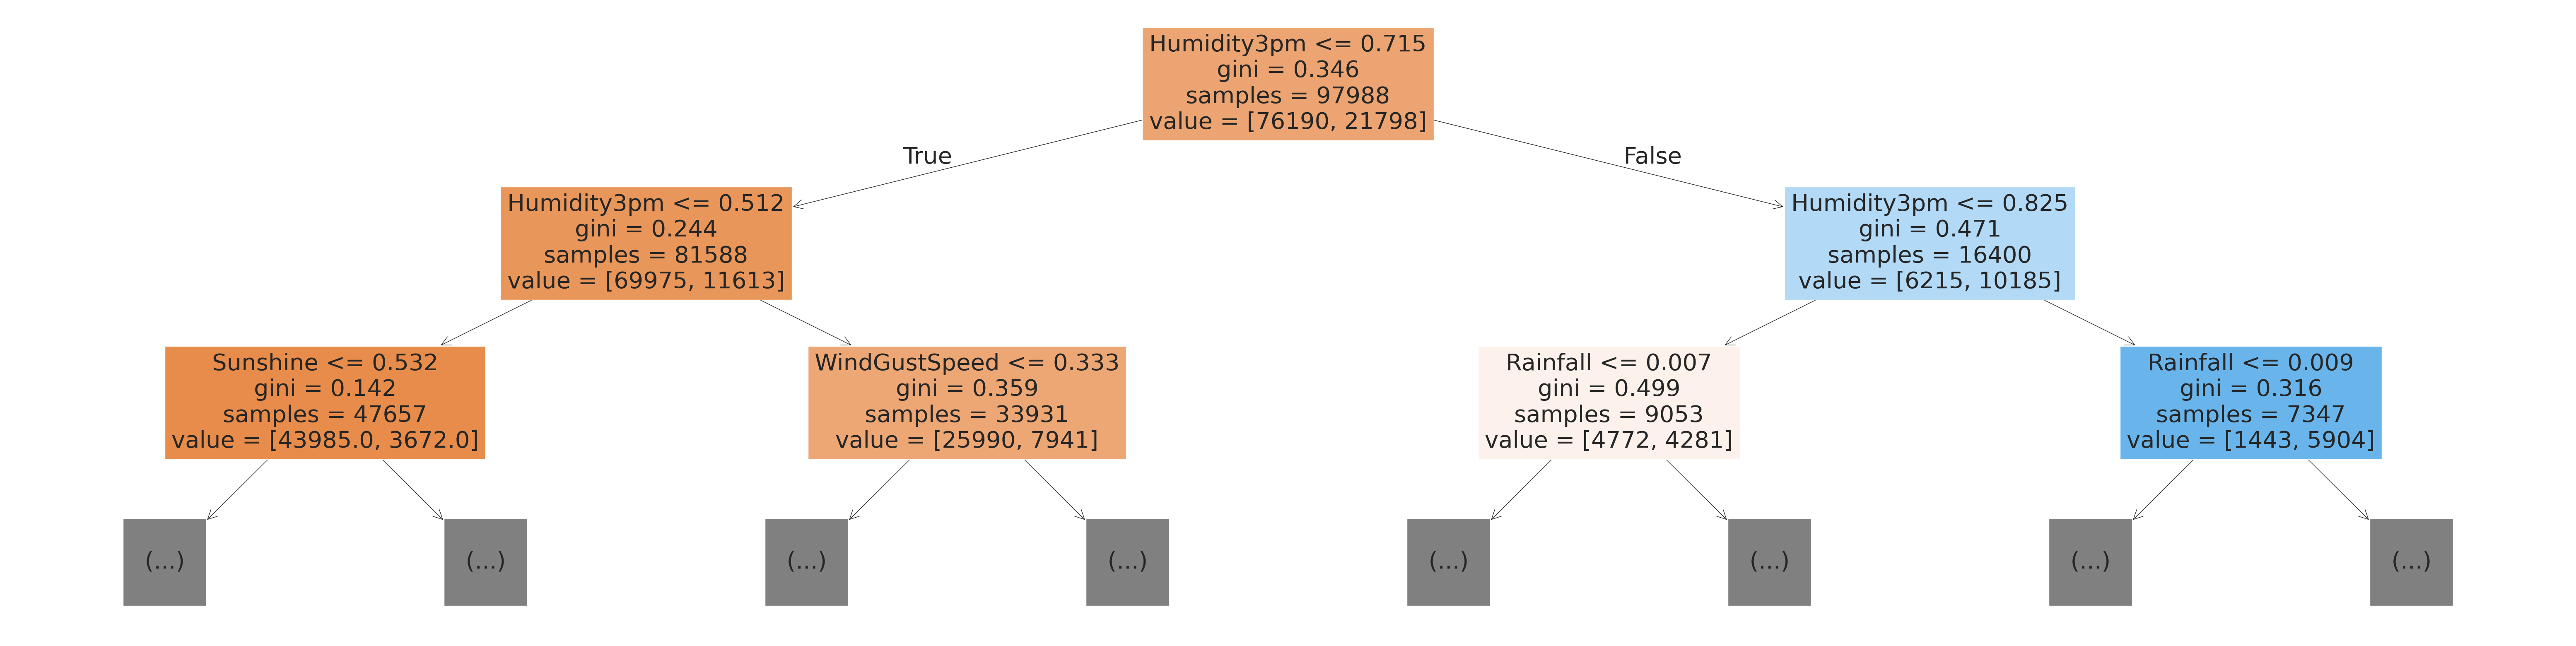

In [20]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

Тут ми чітко бачимо, як модель класифікує кожен екземпляр з допомогою серії рішень. Дерево тут обрізане, але слідуючи будь-яким шляхом від кореневого вузла до листка, ви отримаєте "Так" або "Ні".

Зверніть увагу на значення `gini` в кожному боксі. Це функція втрат, яку використовує дерево рішень для визначення, який стовпець слід використовувати для розділення даних і в якому місці слід розділити стовпець. Нижчий індекс Джині вказує на краще розділення. Ідеальне розділення (лише один клас з кожного боку) має індекс Джині, що дорівнює 0.


Давайте перевіримо глибину створеного дерева.

In [21]:
model.tree_.max_depth

50

Ми також можемо відобразити дерево у вигляді тексту, що може бути легше для розуміння для глибших дерев.

In [22]:
tree_text = export_text(model, max_depth=2, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- truncated branch of depth 27
|   |   |--- Sunshine >  0.53
|   |   |   |--- truncated branch of depth 37
|   |--- Humidity3pm >  0.51
|   |   |--- WindGustSpeed <= 0.33
|   |   |   |--- truncated branch of depth 48
|   |   |--- WindGustSpeed >  0.33
|   |   |   |--- truncated branch of depth 32
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- truncated branch of depth 31
|   |   |--- Rainfall >  0.01
|   |   |   |--- truncated branch of depth 31
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- truncated branch of depth 26
|   |   |--- Rainfall >  0.01
|   |   |   |--- truncated branch of depth 24



### Важливість ознак

На основі обчислень індексу Джині (gini index), дерево рішень призначає значення "важливості" кожній ознаці. Ці значення можуть бути використані для інтерпретації результатів, наданих деревом рішень.

In [23]:
model.feature_importances_.round(2)

array([0.04, 0.03, 0.04, 0.02, 0.05, 0.06, 0.03, 0.03, 0.04, 0.28, 0.04,
       0.06, 0.01, 0.02, 0.04, 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

Давайте перетворимо це на DataFrame і візуалізуємо найважливіші ознаки (features).

In [24]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [25]:
importance_df.head(20)

,feature,importance
9,Humidity3pm,0.278250
5,WindGustSpeed,0.061537
11,Pressure3pm,0.061084
4,Sunshine,0.046878
2,Rainfall,0.043627
8,Humidity9am,0.038775
0,MinTemp,0.037063
10,Pressure9am,0.037047
14,Temp9am,0.035493
15,Temp3pm,0.032650


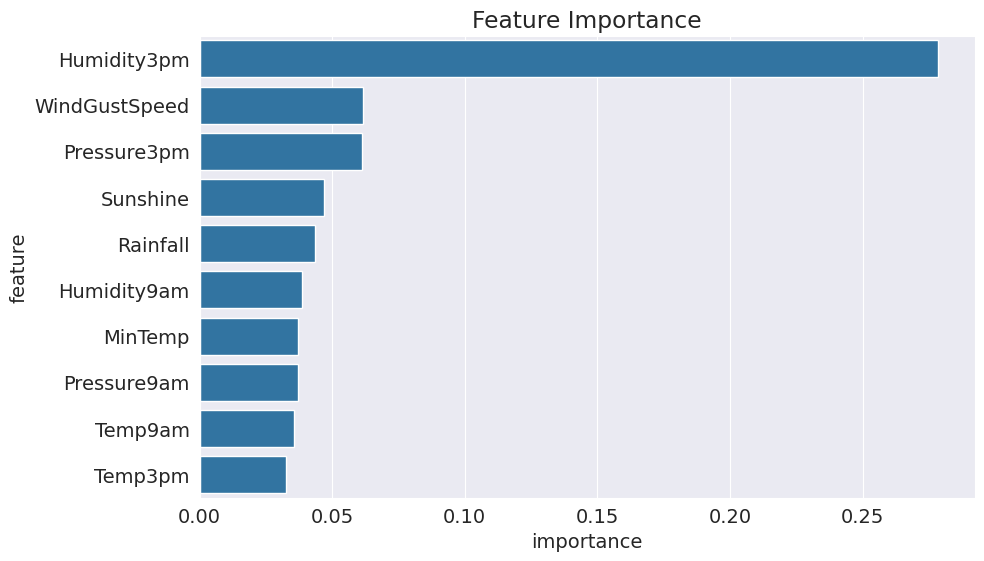

In [26]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Налаштування гіперпараметрів та перенавчання

Як ми бачили в попередньому розділі, наш класифікатор на основі дерева рішень запам'ятав усі навчальні приклади, що призвело до 100% точності на навчальній вибірці, тоді як точність на валідаційній вибірці була лише трохи кращою за базову модель. Це явище називається перенавчанням (overfitting), і в цьому розділі ми розглянемо деякі стратегії для зменшення перенавчання дерева прийняття рішень.

`DecisionTreeClassifier` приймає кілька аргументів, деякі з яких можна змінити для зменшення перенавчання.

In [27]:
?DecisionTreeClassifier

Ці аргументи називаються гіперпараметрами (hyperparameters), тому що їх потрібно налаштовувати вручну (на відміну від параметрів у моделі, які _вивчаються_ з даних). Ми розглянемо кілька гіперпараметрів:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

Зменшуючи максимальну глибину дерева рішень, ми можемо запобігти запам'ятовуванню деревом всіх навчальних прикладів, що може призвести до кращої узагальненості.

In [28]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [29]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

Ми можемо обчислити точність (accuracy) моделі на навчальних та валідаційних наборах даних за допомогою `model.score`.

In [30]:
model.score(X_train, train_targets)

0.8315916234640977

In [31]:
model.score(X_val, val_targets)

0.8348060155655685

Чудово, хоча точність моделі на тренувальних даних знизилася, точність моделі на валідаційних даних значно зросла.

In [32]:
model.classes_

array(['No', 'Yes'], dtype=object)

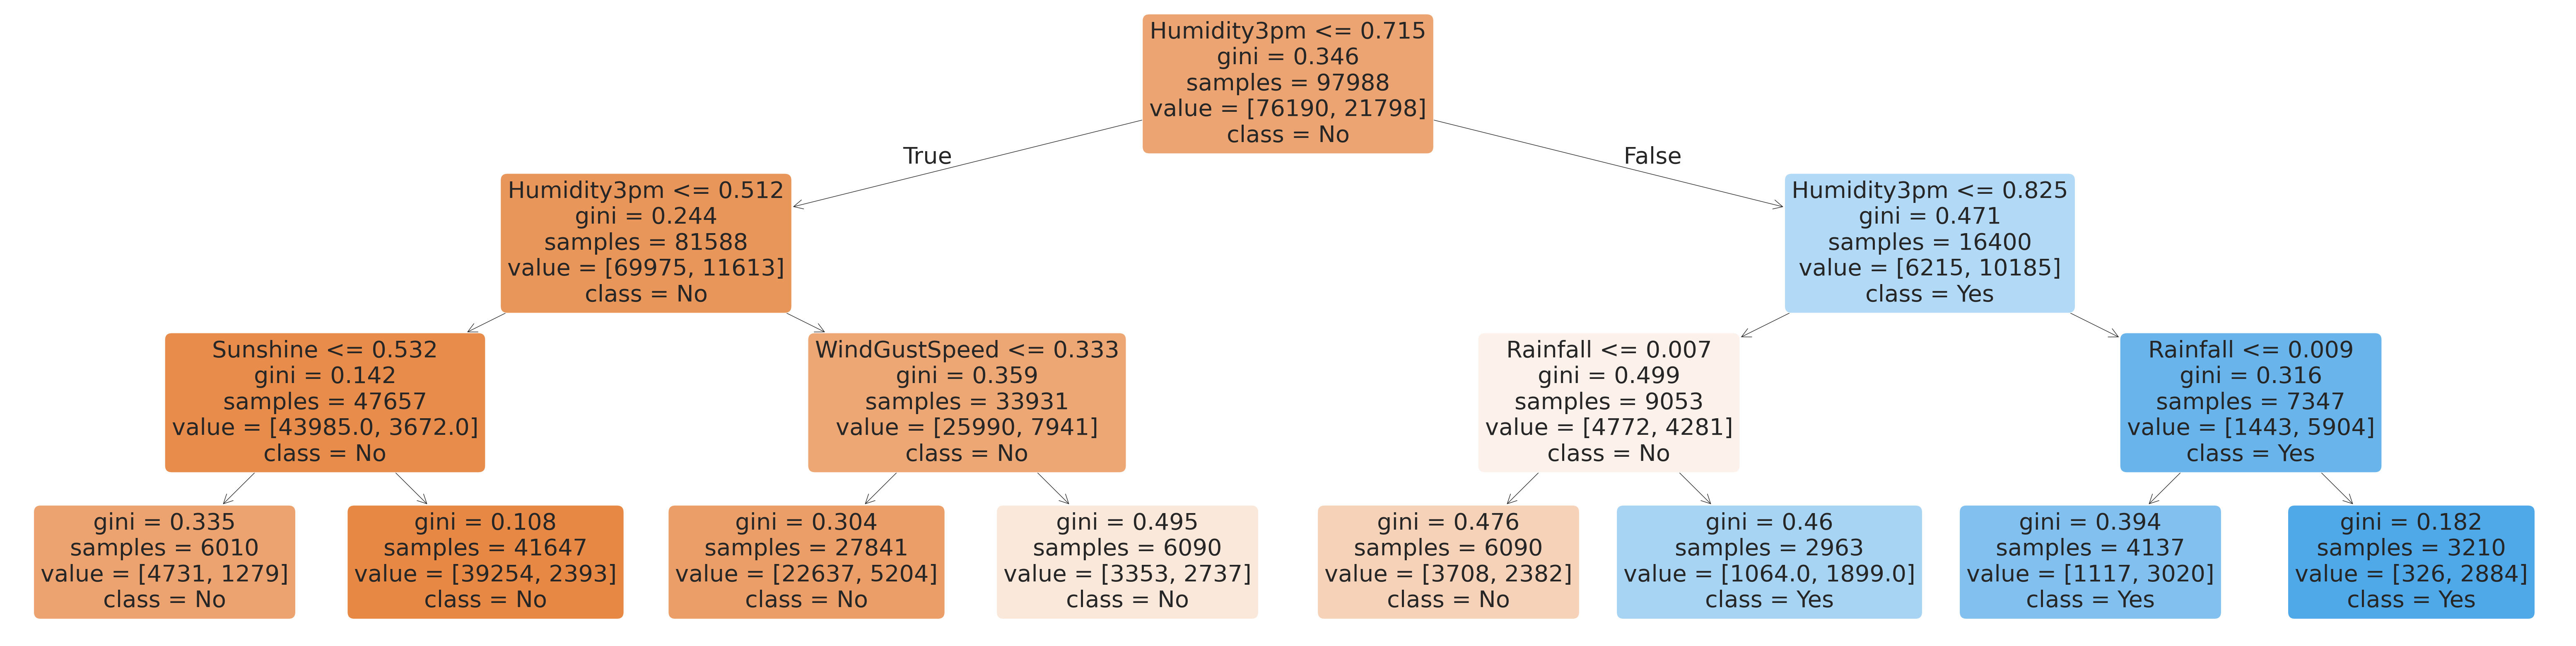

In [33]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

> **ВПРАВА**: Уважно вивчіть діаграму дерева рішень і перевірте, чи чітко розумієте, що означають кожен з термінів `gini`, `samples`, `value` та `class`. Кожен з цих елементів ми вже обговорювали раніше.

In [34]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- class: No
|   |   |--- Sunshine >  0.53
|   |   |   |--- class: No
|   |--- Humidity3pm >  0.51
|   |   |--- WindGustSpeed <= 0.33
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  0.33
|   |   |   |--- class: No
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: No
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: Yes
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes



Давайте експериментувати з різними глибинами, використовуючи допоміжну функцію.

In [35]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_error = 1 - model.score(X_train, train_targets)
    val_error = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_error, 'Validation Error': val_error}

In [36]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: user 45.7 s, sys: 1.38 s, total: 47.1 s
Wall time: 47.2 s


In [37]:
errors_df.style.background_gradient(subset='Validation Error', cmap='Blues_r')

,Max Depth,Training Error,Validation Error
0,1,0.181941,0.176488
1,2,0.176930,0.170695
2,3,0.168408,0.165194
3,4,0.162153,0.161624
4,5,0.157244,0.158113
5,6,0.153131,0.155831
6,7,0.149059,0.154602
7,8,0.144814,0.153842
8,9,0.139374,0.154368
9,10,0.131771,0.154953


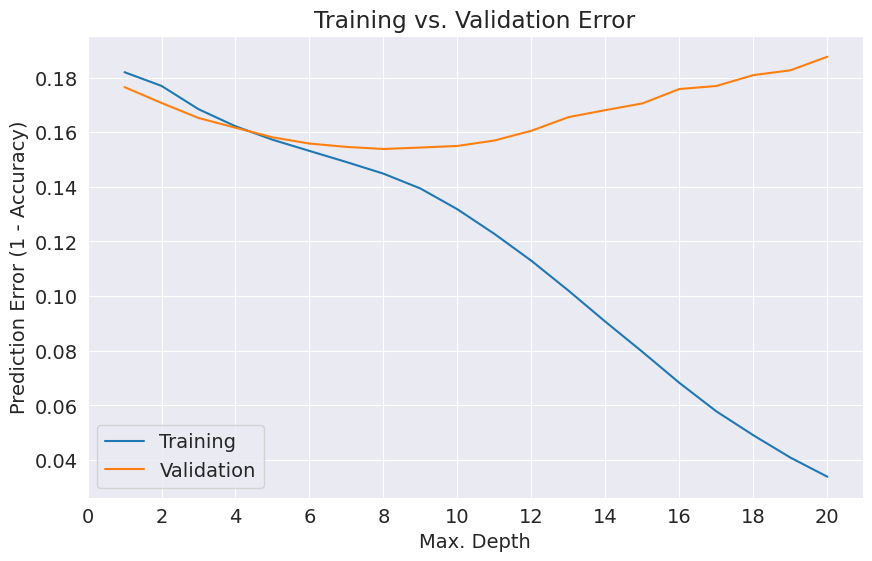

In [38]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

Це поширений шаблон, який ви побачите у всіх алгоритмах машинного навчання:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Часто вам потрібно ретельно налаштовувати гіперпараметри, щоб знайти оптимальну відповідність. У наведеному вище випадку, здається, що максимальна глибина 7 призводить до найнижчої помилки валідації.

In [39]:
model = DecisionTreeClassifier(max_depth=8, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8461583474749839

### `max_leaf_nodes`

Ще один спосіб контролювати розмір складності дерева рішень - обмежити кількість листових вузлів. Це дозволяє гілкам дерева мати різну глибину.

In [40]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [41]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [42]:
model.score(X_train, train_targets)

0.852696248520227

In [43]:
model.score(X_val, val_targets)

0.8471531394464276

In [44]:
model.tree_.max_depth

11

Зверніть увагу, що модель змогла досягти більшої глибини 12 для певних шляхів, зберігаючи інші шляхи коротшими.

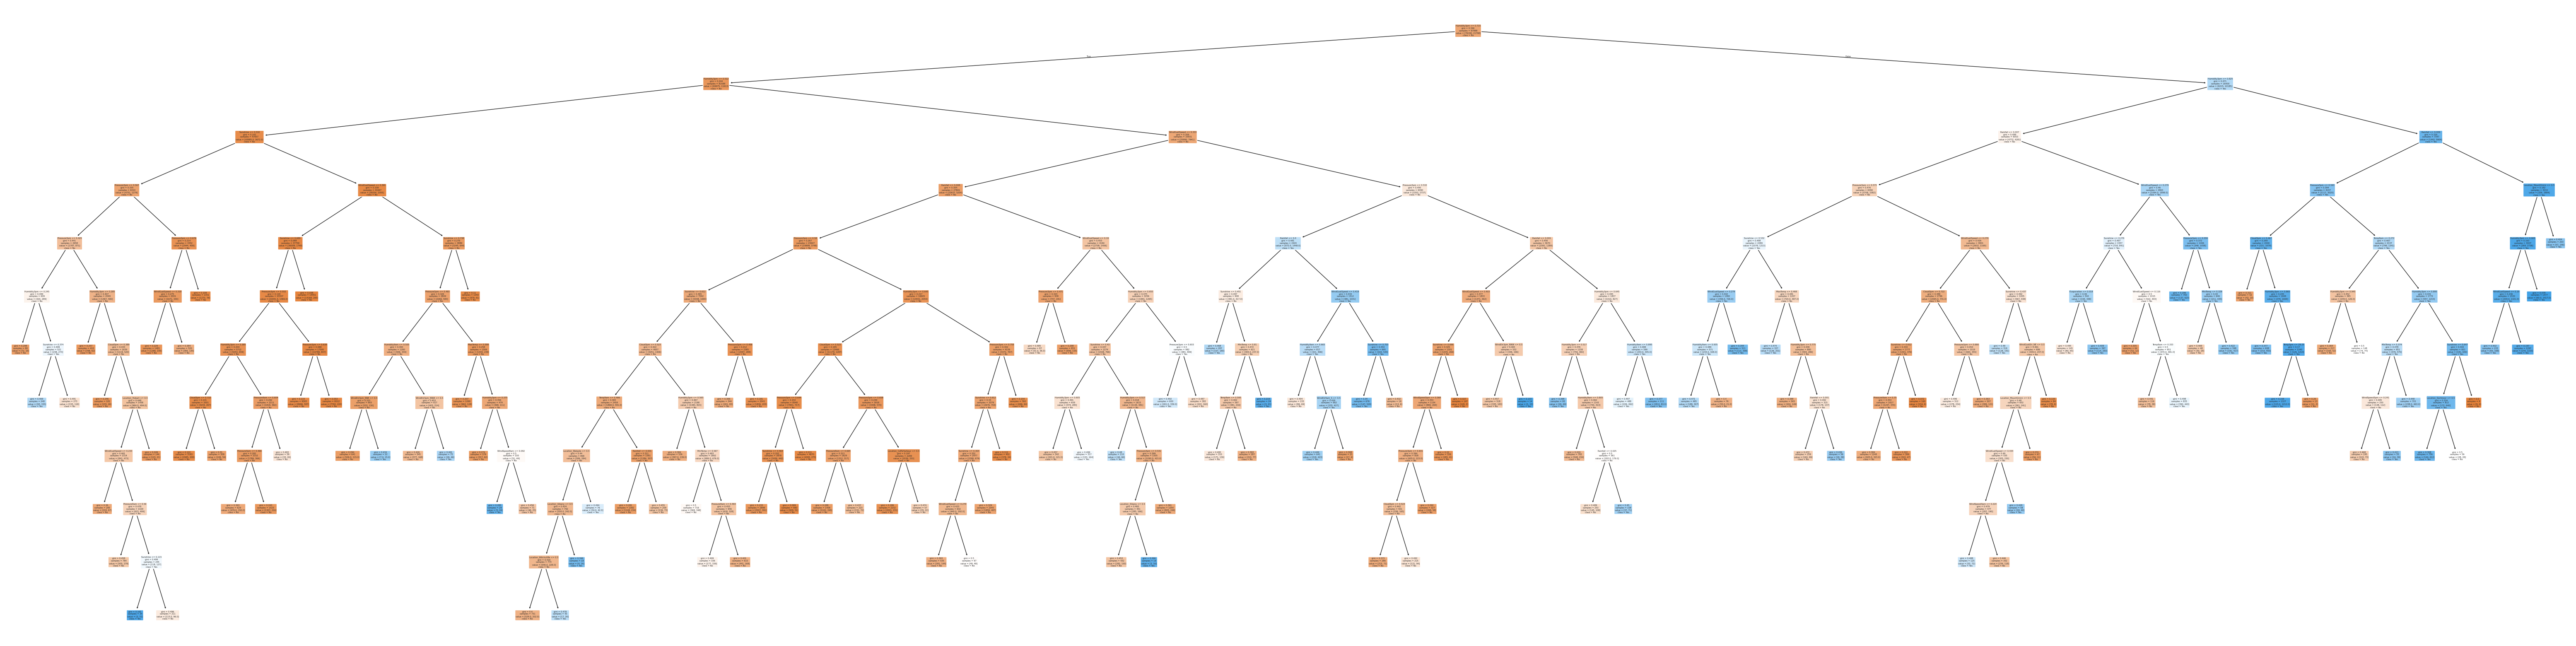

In [45]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [46]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- Pressure3pm <= 0.57
|   |   |   |   |--- Pressure3pm <= 0.42
|   |   |   |   |   |--- Humidity3pm <= 0.24
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.24
|   |   |   |   |   |   |--- Sunshine <= 0.37
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.37
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |--- Pressure3pm >  0.42
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Cloud3pm <= 0.39
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |--- Cloud3pm >  0.39
|   |   |   |   |   |   |   |--- Location_Hobart <= 0.50
|   |   |   |   |   |   |   |   |--- WindGustSpeed <= 0.23
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- WindGustSpeed >  0.23

> **ВПРАВА**: Знайдіть комбінацію `max_depth` і `max_leaf_nodes`, яка призводить до найвищої точності валідації.

In [47]:
best_depth, best_leaf_nodes, best_score = 0, 0, 0
for depth in range(6, 10):
  for leaf_nodes in range(15, 121, 2):
    model = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes = leaf_nodes, random_state=42).fit(X_train, train_targets)
    if model.score(X_val, val_targets) > best_score:
      best_depth, best_leaf_nodes, best_score = depth, leaf_nodes, model.score(X_val, val_targets)
    #print(depth, leaf_nodes, model.score(X_val, val_targets))

print('Best result:', best_depth, best_leaf_nodes, best_score)

Best result: 9 119 0.8465679676985195


> **ВПРАВА**: Досліджуйте та експериментуйте з іншими аргументами `DecisionTree`. Зверніться до документації для деталей: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [48]:
model = DecisionTreeClassifier( max_depth=9, max_leaf_nodes = 119, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)


0.8465679676985195

# Prunning

Більш просунутий метод (але менш поширений метод) для зменшення перенавчання в дереві рішень відомий як обрізка складності вартості (cost-complexity pruning).

Мінімальна вартісна складність обрізки рекурсивно знаходить вузол з "найслабшою ланкою". Найслабша ланка характеризується ефективним альфа, де вузли з найменшим ефективним альфа обрізаються першими. Щоб отримати уявлення про те, які значення `ccp_alpha` можуть бути доречними, `scikit-learn` надає метод `DecisionTreeClassifier.cost_complexity_pruning_path`, який повертає ефективні альфа та відповідні загальні домішки листків на кожному етапі процесу обрізки. Зі збільшенням альфа, більше частин дерева обрізається, що збільшує загальну домішку його листків.

Дізнайтеся більше про це тут: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html .

In [49]:
model = DecisionTreeClassifier(random_state=42)
path = model.cost_complexity_pruning_path(X_train, train_targets)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

У наступному графіку максимальне значення ефективного альфа видалене, оскільки це тривіальне дерево з лише одним вузлом.

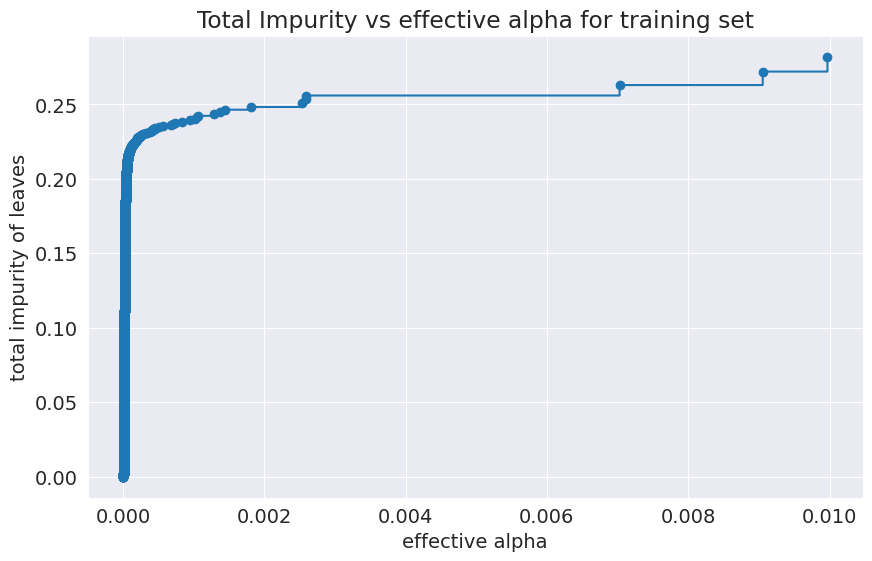

In [50]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

In [51]:
len(ccp_alphas)

4960

In [52]:
models = []
for ccp_alpha in ccp_alphas[-10:]:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    model.fit(X_train, train_targets)
    models.append(model)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        models[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.06386754899460845


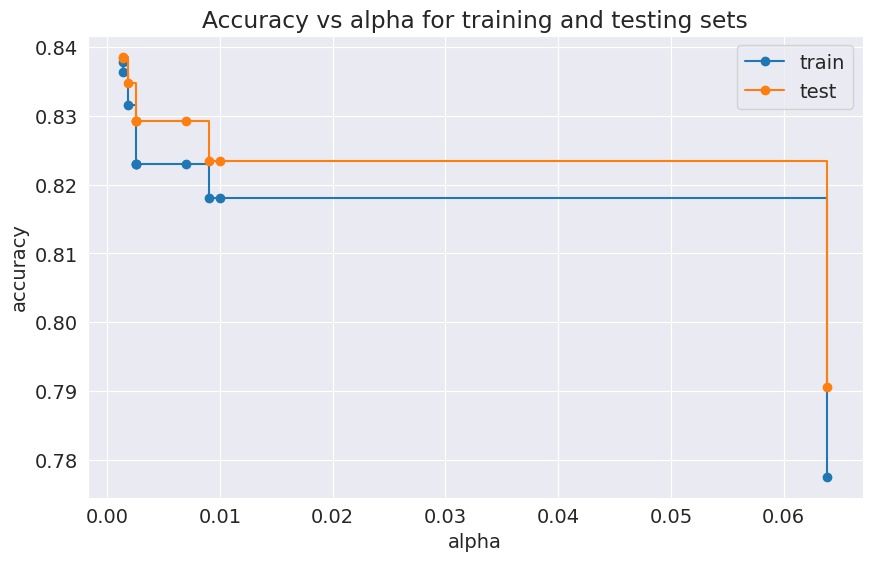

In [53]:
train_scores = [model.score(X_train, train_targets) for model in models]
val_scores = [model.score(X_val, val_targets) for model in models]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[-10:], train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[-10:], val_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [54]:
model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[-20])
model.fit(X_train, train_targets)

DecisionTreeClassifier(ccp_alpha=np.float64(0.000573899499375188),
                       random_state=42)

In [55]:
model.tree_.max_depth

6

In [56]:
model.score(X_train, train_targets)

0.8413785361472833

In [57]:
model.score(X_val, val_targets)

0.8420621452396279